In [1]:
import torch as tr 
import torch.optim as optim
import torch.distributions as distrib
import torch.distributions.transforms as transform
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import nn

import numpy as np 
import matplotlib.pyplot as plt

# Density Ration Estimation for Divergence/Minimization

In simulation-based inference the simulator can be seen as a function that takes some noise $\epsilon \sim p_\epsilon$ and produces $x$ given $\theta$
 $$x = s(\epsilon|\theta)$$
Hence the simulator implicitly defines a likelihood function given by
$$P(x_n \in A|\theta) = P(X^{-1}(x_n)|\theta)= \int_{\{s(\epsilon_n|\theta) \in A\}} p_\epsilon(\epsilon)d\epsilon$$
However this likelihood is typically intractable as the set $\{s(\epsilon_n|\theta) \in A\}$ over which we integrate can be very complicated. After all it is the set of "noise" values for which the simulator produce the outputs contained in the event $A$!

Nontheless the simulator thus defines an **implicit distribution**, that is a distribution that staisfies:
* We cannot evalute the density or any probabilites as we do not have the explicit form.
* We can easily generate samples from it.

In previous approach we tried to estimate the conditional density implied by the simulator directly using conditional density estimation. Then standard inference approaches can be applied directly.

We want to perform variational inference thus we have to minimize some divergence. One popular class are f-divergences. Be $f$ any convex functions then they are defined as 
$$  D_f(p(x)||q(x)) = \int q(x) f\left( \frac{p(x)}{q(x)}\right)dx$$
Many of the standard divergences correspond to simple choices of the function $f$. That is for $f(x) = x\log x$ we obtain the KL divergence. For $f(x) = -\log x$ we obtain the reverse KL divergence.

Problematically with **implicit** likelihood we cannot compute the necessary ratios. However we can sample from it, hence we must estimate it.

In [14]:
def plot_densiy_2d(p, lower=-5, upper=-5):
    x = np.linspace(lower, upper, 500)
    y = np.linspace(lower, upper, 500)
    X1, Y2 = np.meshgrid(x,y)

    pos = np.empty(X1.shape + (2,))
    pos[:, :, 0] = X1
    pos[:, :, 1] = Y2
    logp = model.log_prob(tr.tensor(pos).float()).detach()

    fig = plt.figure()
    plt.contourf(X1, Y2, logp.reshape(500,500).exp())
    plt.show()

## 1) KL Divergence Minimization between implicit distributions

The KL divergence between distributions $p$ and $q$ is defined as 
$$ D_{KL}(p(x) ||q(x)) := \mathbb{E}_p \left[ \log\left(\frac{p(x)}{q(x)} \right)\right]$$
Be $r^*(x) := \frac{p(x)}{q(x)}$ the density ratio then we can express it also as $D_KL(p(x)||q(x)) = \mathbb{E}_p\left[ \log r^*(x)\right]$. This density ratio is crucial for computing not only the KL but any $f$ divergence. Typically we cannot compute the integral explicitly but for some simple distribution e.g. Gaussians we can callculate it explicitly.

In [75]:
x = tr.linspace(-5,5,1000)

KL divergence:  tensor(0.4431)


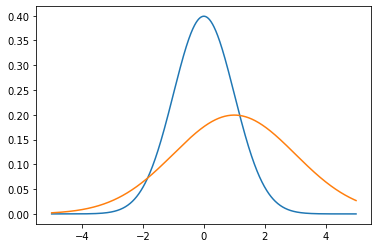

In [15]:
p1 = distrib.Normal(0,1)
p2 = distrib.Normal(1,2)

plt.plot(x, p1.log_prob(x).exp())
plt.plot(x, p2.log_prob(x).exp())
kl_div = distrib.kl.kl_divergence(p1,p2)
print("KL divergence: ", kl_div)

If we atleast have the density ration we could at least approximate it through Monte Carlo e.g.
$$ D_{KL}(p(x)||q(x)) = \mathbb{E}[\log r^*(x)] \approx \frac{1}{M} \sum_{i=1}^M \log r^*(x_i) \qquad x_i \sim p(x)$$


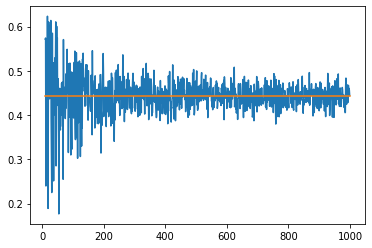

In [120]:
Ns = tr.arange(10,1000, 1)
KL_approx = tr.zeros(len(Ns))
for i in range(len(Ns)):
    N = Ns[i]
    p_samples = p1.sample_n(N)
    KL_approx[i] = tr.mean(p1.log_prob(p_samples)-p2.log_prob(p_samples))
plt.plot(Ns,KL_approx)
plt.plot(Ns,kl_div*tr.ones(len(Ns)))

However in the case of implicit distribution we cannot even estiamte the denstity ratio. Nonetheless as we will demonstrate we still can approximate density ratios. This can be done via a classifier that discriminates between samples of the distributions.

Suppose we have $N_p$ and $N_q$ samples from $p(x)$ and $q(x)$. Then we form the labeled dataset
$$ (x_1, \dots, x_N) = (x_p^1, \dots x_p^{N_p}, x_q^1, \dots, x_q^{N_q})$$
$$ (y_1m \dots, y_N) = (1,\dots, 1,0, \dots, 0)$$
That is each sample of $p$ is labeld by $1$ and each sample form $q$ is labeld by $0$.

By construction we have that 
$$ p(x) = P(x|y=1) \qquad q(x) = P(x|y=0)$$
Using Bayes rule we can write
$$ P(x|y) = \frac{P(y|x)P(x)}{P(y)}$$
and thus we can express the density ration $r^*(x)$ as
$$ r^*(x) = \frac{p(x)}{q(x)} = \frac{P(x|y=1)}{P(x|y=0)} = \left(\frac{P(y=1|x)P(x)}{P(y=1)}\right) \left(\frac{P(y=0|x)P(x)}{P(y=0)}\right)^{-1} = \frac{P(y=0)}{P(y=1)} \frac{P(y=1|x)}{P(y=0|x)}$$
We can approximate the first ratio of marginal densities by the ratio of samples sizes 
$$ \frac{P(y=0)}{P(y=1)} = \frac{N_q}{N_p}$$
Hence if we choose $N_q=N_p$ this term disappears. Thus we can write the density ration complettely in terms of class posterior probability
$$ r^*(x) = \frac{P(y=1|x)}{P(y=0|x)}$$

We can rewrite this expression as
$$ r^*(x) = \frac{P(y=1|x)}{P(y=0|x)} = \frac{P(y=1|x)}{1-P(y=1|x)} =  \exp\left(\log\left( \frac{P(y=1|x)}{1-P(y=1|x)} \right)\right)= \exp\left(\sigma^{-1}\left(P(y=1|x)\right)\right)$$
where $\sigma^{-1}$ is the logit function, the inverse of the sigmoid function.

Notice that if the densities are available we can recover the exact class-posterior probabilities by
$$ P(y=1|x) = \sigma(\log r^*(x)) = \frac{p(x)}{p(x)+q(x)}$$

In our case we do not have the densities, but can learn a classifier the approximate the class-posterior probability. Particullary in this framework **logistic regression** can be used to learn the class-posterior probabilities. That is be $f_\theta(x)$ a logsitc regressor, thus we can estimate the density ratio by
$$ r_\theta(x) = \exp(\sigma^{-1}(f_\theta(x)))$$
Typically we estimate the log-odds $\log r_\theta(x) = \sigma^{-1}(f_\theta(x))$. We learn it using a proper scoring rule such that we get well calibrated probabilities 
$$ \mathcal{L}(\theta):= -\mathbb{E}_p[\log \sigma (\log r_\theta(x))] -\mathbb{E}_q[\log (1-\sigma (\log r_\theta(x)))] $$

In [474]:
N = 1000
X_p1 = p1.sample_n(N)
X_p2 = p2.sample_n(N)

In [475]:
def loss_disc(model,X1,X2):
    loss_p = tr.log(model(X1)+ 1e-6).mean()
    loss_q = tr.log(1-model(X2) + 1e-6).mean()
    return -loss_p - loss_q

In [476]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, hidden_dim=20, hidden_layers=2):
        super().__init__()
        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim 
        net = [nn.Linear(input_dim, hidden_dim), nn.ReLU()]
        for i in range(hidden_layers):
            net.extend([nn.Linear(hidden_dim, hidden_dim), nn.ReLU()])
        self.fc_e = nn.Sequential(*net)
        self.fc_o = nn.Sequential(nn.Linear(hidden_dim,1), nn.Sigmoid())
    def forward(self, x):
        x = x.reshape(-1,self.input_dim)
        h = self.fc_e(x)
        p_y = self.fc_o(h)
        return p_y
model = LogisticRegression(1)

In [575]:
def train_discriminator(model,X, iters=301, verbose=True):
    optimizer = optim.Adam(model.parameters())
    for i in range(iters):
        optimizer.zero_grad()
        ll = loss_disc(model,X_p1,X_p2)
        ll.backward()
        optimizer.step()
        if i % 50 == 0 and verbose:
            print(ll.data)
train_discriminator(model,X)

tensor(1.1352)
tensor(1.1352)
tensor(1.1351)
tensor(1.1351)
tensor(1.1350)
tensor(1.1350)
tensor(1.1349)


In [464]:
def r(model, x):
    return tr.logit(model(x))

So lets estimate the KL divergence also by MC 

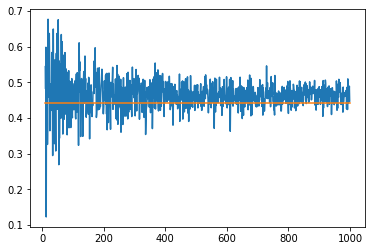

In [448]:
Ns = tr.arange(10,1000, 1)
KL_approx = tr.zeros(len(Ns))
for i in range(len(Ns)):
    N = Ns[i]
    p_samples = p1.sample_n(N)
    KL_approx[i] = tr.mean(r(model,p_samples).detach())
plt.plot(Ns,KL_approx)
plt.plot(Ns,kl_div*tr.ones(len(Ns)))

That looks rather good. As we have know the densites we know the optimal predictor. Lets compare how "good" we learned it.

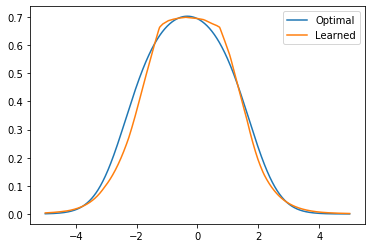

In [449]:
x = tr.linspace(-5,5,1000)
opt_class = p1.log_prob(x).exp()/(p1.log_prob(x).exp() + p2.log_prob(x).exp())
learned = model(x).detach()
plt.plot(x, opt_class)
plt.plot(x, learned)
plt.legend(["Optimal", "Learned"])

## 2) Adversial learning

Direct estimation of the data distribution is often infeasible. Instead we may consider some paramteric transformation $T_\phi: z \mapsto x$ that takes as input $z$ drawn from a simple distribution $p_0(z)$. The output of this generative process is assumed to be sample from the implicit distribution 
$$ x \sim q_\phi(x) \iff x= T_\phi(z) \quad z \sim p(z)$$
By optimizing the paramters we can $\phi$ we can fit this to the reald data distrubtion $p(x)$.

One approach is to fit the densities is by f-divergence minimization e.g. minimizing the KL divergence. However as $q_\phi$ is only implicitly defined we cannot calculate the density ratio and thus are unable to perform optimization.

Hence we may use the estimator discussed above. Hence we introduce a classifier $f_\theta$ that discriminates between real and synthetic samples. Then we optimize $T_\phi$ to synthsize samples that are indistinguishable to the classifier $f_\theta$. This can be achieved by simultaneously optimizing the binary cross-entropy loss
$$ \min_\phi \max_\theta \mathbb{E}_q[\log f_\theta(x)] + \mathbb{E}_p[\log(1-f_\theta(x))] = \min_\phi \max_\theta \mathbb{E}_p[\log f_\theta(x)] + \mathbb{E}_{p_0}[\log(1-f_\theta(T_\phi(z)))]$$

This is what **Generative adversarial networks (GANs)** do.

### Variational inferece with implicit distributions

To perform variational inference in such models we would introduce a variational distribution for each observation $x_n$, but doing so requires a lot of paramters and thus we perfrom **amortised inference**. We introduce a recognition model $q_\phi(z \mid x)$.

Our goal is to minimize the backward KL divergence between $q_\phi$ and the true posterior which we can rewrite as
$$ KL(q_\phi(z\mid x)|| p(x\mid y)) = KL(q_\phi(z\mid x)||p_\theta(x)) - \mathbb{E}_q[\log p(x|z)] = \mathbb{E}_q\left[ \log \frac{q_\phi(z\mid x)}{p_\theta(x)}\right]-\mathbb{E}_q[\log p(x|z)]$$
As discussed above we can approximate this density ratios using a disscriminator, hence we can keept prior and posterior implicit! This is what is called the **prior-contrastive** approach. However in the set of likelihood free inference the prior is known but not the likelihood. Notice that we can write
\begin{align*}
KL(q_\phi(z\mid x)|| p(x\mid y)) &= \mathbb{E}\left[ \log \frac{q_\phi(z\mid x)}{p(z\mid x)}\right] \\
&=  \mathbb{E}\left[ \log \frac{q_\phi(z\mid x)p(x)}{p(x\mid z)p(z)}\right]\\
&= \mathbb{E}\left[ \log \frac{q_\phi(z\mid x)p(x)}{p_\theta(x\mid z)p(z)}\right] + \log p^*(x) - \log p^*(x)\\
&= KL(q_\phi(z\mid x)p^*(x)||p_\theta(x,z)) - KL(p^*(x)|p(x))
\end{align*}
Notice that $p^*(x)$ is the true data distribution (which we typically approximate with the empirical one) and $p(x)$ is the marginal likelihood. The later term does not contain any paramters and thus can be ignored. This method is called the **joint contrastive from**.

The inference works in a scheme similar to GANs:
* First we minimize the discriminator loss, with that we approximate the density ratios 
* Next we minimize the KL divergence 

Lets consider an example where we want to perform a Gaussain approximation for a mixture of Gaussian.

In [63]:
mix = distrib.Categorical(tr.tensor([0.3,0.7]))
components = distrib.Normal(tr.tensor([-3.,2.]), tr.tensor([1.,0.5]))
gmm = distrib.MixtureSameFamily(mix,components)

In [748]:
mu = tr.zeros(1,requires_grad=True)
sig = tr.ones(1, requires_grad=True)
q = distrib.Normal(mu,sig)

Lets first minimize the KL divergence using the known densities...

In [749]:
optimizer = optim.Adam([mu,sig],lr=0.01)
losses = []
for i in range(500):
    optimizer.zero_grad()
    samples = mu + sig*tr.randn(512)
    loss = tr.mean(q.log_prob(samples) - gmm.log_prob(samples))
    loss.backward()
    optimizer.step()
    losses.append(loss.data)

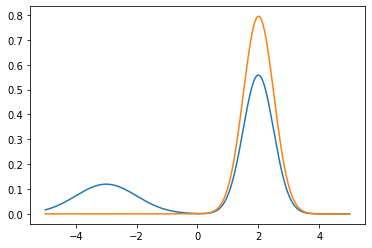

In [750]:
plt.plot(x,gmm.log_prob(x).exp())
plt.plot(x,q.log_prob(x).detach().exp())

Lets try to do this implicitly, by computing the likelihood ratios using the adversial approach!

In [878]:
mu = tr.ones(1,requires_grad=True)
sig = tr.ones(1, requires_grad=True)
q = distrib.Normal(mu,sig)

In [879]:
def train(q,p,iters=100, discrimnator_iters=10):
    losses = []
    discriminator = LogisticRegression(1, hidden_layers=2)
    q_optimizer = optim.Adam([mu,sig], lr=0.01)
    disc_optimizer = optim.Adam(discriminator.parameters(),lr=0.01)
    for i in range(iters):
        q_samples = mu + sig*tr.randn(1024)
        p_samples = gmm.sample_n(1024)
        # Optimice discriminator
        for i in range(discrimnator_iters):
            disc_optimizer.zero_grad()
            l_discrimnator = loss_disc(discriminator,q_samples,p_samples)
            l_discrimnator.backward(retain_graph=True)
            disc_optimizer.step()
        # Optimize q
        q_optimizer.zero_grad()
        logratio = tr.logit(discriminator(q_samples))
        #print(logratio[:5])
        #print((q.log_prob(q_samples) - p.log_prob(q_samples))[:5])
        klloss = tr.mean(logratio)
        klloss.backward()
        q_optimizer.step()
        losses.append(klloss.data)
    return losses

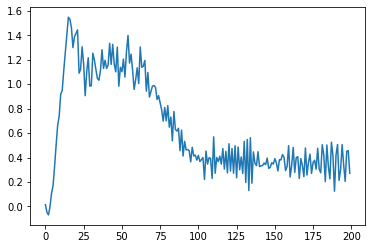

In [880]:
plt.plot(train(q,gmm,iters=200, discrimnator_iters=2))

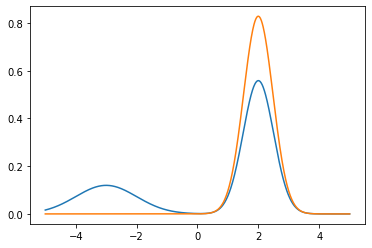

In [881]:
plt.plot(x,gmm.log_prob(x).exp())
plt.plot(x,q.log_prob(x).detach().exp())

## 3) Variational f-divergence minimization

Consider one member of the f-divergence family the Jensen-Shanndon Divergence which can be written as
$$ D_{JS}(q(x)||p(x)) = \frac{1}{2} D_{KL}\left(q(x)|| \frac{q(x)+p(x)}{2}\right) + \frac{1}{2} D_{KL}\left(p(x)|| \frac{q(x)+p(x)}{2}\right)$$
Recall that we train the discriminator by maximizing the cross entropy loss. We obtain the optimal discriminator with loss equaling to 
$$\sup_\theta \mathbb{E}_q[\log f_\theta(x)] + \mathbb{E}_p(\log (1-f_\theta(x)))$$
Notice that we can rewrite this expression by 
\begin{align*}
\sup_\theta \mathbb{E}_q[\log f_\theta(x)] + \mathbb{E}_p(\log (1-f_\theta(x))) &= \mathbb{E}_q[\log P(y=1|x)] + \mathbb{E}_p[\log P(y=0|x)]\\
&= \mathbb{E}_q\left[\frac{p(x)}{p(x)+q(x)}\right] + \mathbb{E}_p\left[\frac{q(x)}{p(x)+q(x)}\right]\\
&= \mathbb{E}_q\left[\frac{1}{2}\frac{p(x)}{0.5(p(x)+q(x))}\right] + \mathbb{E}_p\left[\frac{1}{2}\frac{q(x)}{0.5(p(x)+q(x))}\right]\\
&= D_{KL}\left(q(x)|| \frac{q(x)+p(x)}{2}\right) +  D_{KL}\left(p(x)|| \frac{q(x)+p(x)}{2}\right) - 2\log 2\\
&= 2 D_{JS}(q(x)||p(x)) - \log 4
\end{align*}
As we minimize this in the out loop what we are doing is actually minimizing the Jensen-Shannon divergence up to some constants! Thus the adversial learning in e.g. GAN's can be seen as a special case of f-divergence minimization.

So this rises the question if we can find another more general discriminator loss that bounds any given f-divergence?

Yes actually there are several approaches! Recall the f-divergence family is defined as 
$$ D_f(q||p) = \int p(x) f \left( \frac{q(x)}{p(x)} \right) dx$$
where $f$ is **convex**. This convexity has several implications, because then there exist a **convex conjugate** 
$$ f^*(t) := \sup_{u \in dom(f)} \left\{ t  u - f(t)\right\}$$
The function $f^*$ is again convex and lower semincontinuous. The pair $(f,f^*)$ are dual to another in the sense that $f^{*^*} =f$. Therefore we can also represent $f$ as $f(u) = \sup_{t \in dom(f^*)} \left\{ tu-f^*(t)\right\}$.

We can leverage this representation to obtain a lower bound for any $f-divergence$:
\begin{align*}
D_f(q||p) &= \int p(x) sup_{t \in dom(f^*)} \left\{t \frac{p(x)}{q(x)} - f^*(t)  \right\}dx\\
& \geq \sup_{T \in \mathcal{T}} \left( \int p(x)T(x)dx - \int q(x)f^*(T(x))dx\right)\\
&= \sup_{T \in \mathcal{T}} (\mathbb{E}_q[T(x)] - \mathbb{E}_p[f^*(T(x))])\\
\end{align*}
where $\mathcal{T}$ is an arbitrary class of functions. The above derivation yields a lower bound because we use Jensen's inequality to swap integation and supremum. Second, the class $\mathcal{T}$ may only contain a subset of possible functions.

This bound is tight under mild conditions when $T^*(x) = f*\left(\frac{q(x)}{p(x)})


Simple choices of $f$ lead to well known divergences, which also have closed from complex conjuate:
* Forward KL divergence:  $f(x) = x\log x$ and $T^*(x) = 1+ \log \frac{p(x)}{q(x)}$
* Reverse KL divergence_  $f(x) = -\log x$ and $T^*(x) = -\frac{q(x)}{p(x)}

So we can differentiate between methods that minimize the **primal objective** $\inf_{q} D_f(p||q)$ and methods that minimize the **dual objective** $\inf_G sup_T \mathbb{E}_+[T(X)] - \mathbb{E}[f^*(T(G(Z)))]$. For example VAE minimize the primal objective where GANs minimize the dual objective.

Further we can come up with a upper bound, by the observation that 
$$ D_f(p(x)||q(x)) \leq D_f(p(x,z)||q(x,z))$$
This can be shown using jensens inequality:
$$ D_f(p(x,z)||q(x,z)) = \int q(x) \int q(z|x)f\left( \frac{p(x,z)}{q(x,z)} \right) dzdx \geq \int q(x) f\left( \int q(z|x) \frac{p(x,z)}{q(z|x)q(x)} dz  \right)dz = D_f(p(x)||q(x))$$

Notice that the ELBO is a special case of this. Whole the bound holds for any f-divergence it can be different to apply e.g. the forward KL divergence is ill defined as the data distribution has only support on training data points. One solution is the **Spread f-divergence**. For distributions $q(x)$ and $p(x)$ which have disjoint support we define new distribution 
$$ p(y) = \int p(y|x)p(x)dx \qquad q(y) = \int p(y|x) q(x)dx$$
where $p(y|x)$ is a noise process such that $p(y)$ and $q(y)$ have same support e.g. it can be a Gaussian $p(y|x) = \mathcal{N}(y|x,\sigma^2)$ then $p(y),q(y)$ have both support on $\mathbb{R}$. The speared f-divergence is hence defined by 
$$ D_f'(p(x)||q(x)) = D_f(p(y)||q(y))$$
The auxiliary upper bound can be easiy applied, that is 
$$ D_f'(p(x)||q(x)) \leq D_f(p(y,z)||q(y,z))$$
For example for the reverse KL objective we have 
$$KL'(p_\theta(x)||\hat{p}(x)) = KL(p_\theta(y)||\hat{p}(y)) \leq KL(p_\theta(y|z)p(z)||p(y)q_\phi(z|y))$$
In the case of a Gaussian noise process $p(y|x)$ we obtian a mixture of Gaussian 
$$\hat{p}(y) = \int p(y|x)\hat{p}(x)dx = \frac{1}{N\sqrt{2\pi\sigma^2}} \sum_{n=1}^N e^{-\frac{(y-x_n)^2}{2\sigma^2}}$$

In [978]:
def f_KL_rev(u):
    return -tr.log(u)
def f_KL_for(u):
    return u*tr.log(u)
def f_JS(u):
    return -(u+1)*tr.log((1+u)/2) + u*tr.log(u)
def f_KL_rev_conj(t):
    return -1-tr.log(-t)
def f_KL_for_conj(t):
    return tr.exp(t-1)
def f_JS_conj(t):
    return -tr.log(2-tr.exp(t))

We we first use the variational lower bound on f-divergences. Todoso we wil use two neural networks, the generative model $q_\phi$ and a neural vector for implemnetning the transform $T_\psi$. T is our variational function, we approximate the supremum by maximizing following expression with respect to $\psi$
$$ \mathcal{L}(\phi,\psi) = \mathbb{E}_p(T_\psi(x)] - \mathbb{E}_{q_\theta}[f^*(T_\psi(x))]$$
However we also have tot respect the domain of $f^*$, thus we will paramterize $T_\psi(x) = g_f(T_\psi(x))$. Thus $g_f$ is just the output activation function of the neural network such that we respect the domain of $f^*$. 

In [946]:
class VariationalTransform(nn.Module):
    def __init__(self, input_dim, div_type="KL reverse", hidden_dim=20, hidden_layers=2):
        super().__init__()
        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim 
        self.div_type = div_type
        net = [nn.Linear(input_dim, hidden_dim), nn.ReLU()]
        for i in range(hidden_layers):
            net.extend([nn.Linear(hidden_dim, hidden_dim), nn.ReLU()])
        self.fc_e = nn.Sequential(*net)
        self.fc_o = nn.Linear(hidden_dim,1) 

    def forward(self, x):
        x = x.reshape(-1,self.input_dim)
        h = self.fc_e(x)
        if self.div_type == "KL reverse":
            y = -tr.exp(-self.fc_o(h))
        elif self.div_type == "JS":
            y = np.log(2) - tr.log(1+tr.exp(-self.fc_o(h)))
        else:
            y = self.fc_o(h)
        return y

Lets consider again the task to fit Gaussian variational distribution to a mixture of gaussians and do this using the forward KL, the reverse KL and the JS divergence. As we will see the results depend strongly on the choice of divergence.

In [884]:
q = distrib.Normal(tr.zeros(1,requires_grad=True),tr.ones(1, requires_grad=True))

In [1063]:
def train_exact_div(q,p, steps=500, div="KL reverse"):
    mu = q.loc 
    sig = q.scale
    optimizer = optim.Adam([mu,sig],lr=0.01)
    if div=="KL reverse":
        def loss_f():
            samples_q = mu + sig*tr.randn(512)
            return tr.mean(q.log_prob(samples_q) - p.log_prob(samples_q))
    elif div=="KL forward":
        def loss_f():
            samples_p = p.sample_n(512)
            return tr.mean(p.log_prob(samples_p) - q.log_prob(samples_p))
    elif div=="JS":
        def loss_f():
            samples_q = mu + sig*tr.randn(512)
            samples_p = p.sample_n(512)
            m = lambda x: 0.5*(p.log_prob(x) + q.log_prob(x))
            KL_q_m = tr.mean(q.log_prob(samples_q) - m(samples_q))
            KL_p_m = tr.mean(p.log_prob(samples_p) - m(samples_p))
            return 0.5*KL_q_m + 0.5*KL_p_m 
    else:
        raise NotImplementedError()
    for i in range(steps):
        optimizer.zero_grad()
        loss = loss_f()
        loss.backward()
        optimizer.step()

In [1064]:
q_KL_rev = distrib.Normal(tr.ones(1,requires_grad=True),tr.ones(1, requires_grad=True))
q_KL_for = distrib.Normal(tr.ones(1,requires_grad=True),tr.ones(1, requires_grad=True))
q_JS = distrib.Normal(tr.ones(1,requires_grad=True),tr.ones(1, requires_grad=True))

In [1065]:
train_exact_div(q_KL_rev, gmm, div="KL reverse")
train_exact_div(q_KL_for, gmm, div="KL forward")
train_exact_div(q_JS, gmm, div="JS")

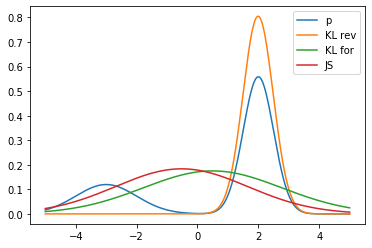

In [1066]:
plt.plot(x,gmm.log_prob(x).exp())
plt.plot(x,q_KL_rev.log_prob(x).detach().exp())
plt.plot(x,q_KL_for.log_prob(x).detach().exp())
plt.plot(x,q_JS.log_prob(x).detach().exp())
plt.legend(["p", "KL rev", "KL for", "JS"])

One can see the solution depends heavily on the choice of divergence. The reverse KL divergence is known to be **mode seeking** whereas forward KL is **mean covering**. The JS is a combination of both...

In [1044]:
def loss(T, x_p, x_q, f_star=f_KL_rev_conj):
    E_p = T(x_p).mean()
    E_q = -f_star(T(x_q)).mean()
    return -(E_p+E_q)

In [1101]:
def train_f_div(q,p,iters=100, T_iters=1, div="KL reverse"):
    losses = []
    mu = q.loc 
    sig = q.scale
    T = VariationalTransform(1,div_type=div)
    q_optimizer = optim.Adam([mu,sig], lr=0.01)
    T_optimizer = optim.Adam(T.parameters(),lr=0.01)
    if div== "KL reverse":
        f_star = f_KL_rev_conj
    elif div == "KL forward":
        f_star = f_KL_for_conj
    elif div == "JS":
        f_star = f_JS_conj
    for i in range(iters):
        q_samples = mu + sig*tr.randn(1024)
        p_samples = gmm.sample_n(1024)
        # Optimice T
        for _ in range(T_iters):
            T_optimizer.zero_grad()
            f_div_loss = loss(T, p_samples, q_samples, f_star=f_star)
            f_div_loss.backward(retain_graph=True)
            T_optimizer.step()
        # Optimize q
        q_optimizer.zero_grad()
        f_div_loss = -loss(T, p_samples, q_samples, f_star=f_star)
        f_div_loss.backward()
        q_optimizer.step()
        losses.append(f_div_loss.data)
    return losses

In [1110]:
q_KL_rev = distrib.Normal(tr.ones(1,requires_grad=True),tr.ones(1, requires_grad=True))
q_KL_for = distrib.Normal(tr.ones(1,requires_grad=True),tr.ones(1, requires_grad=True))
q_JS = distrib.Normal(tr.ones(1,requires_grad=True),tr.ones(1, requires_grad=True))

In [1114]:
l1 = train_f_div(q_KL_rev, gmm, iters=200, div="KL reverse")
l2 = train_f_div(q_KL_for, gmm, iters=200, div="KL forward")
l3 = train_f_div(q_JS, gmm, iters=200, div="JS")

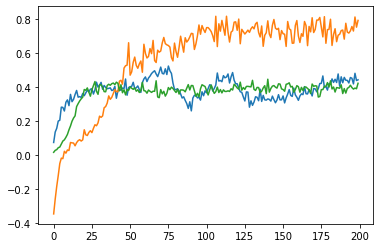

In [1115]:
plt.plot(l1)
plt.plot(l2)
plt.plot(l3)

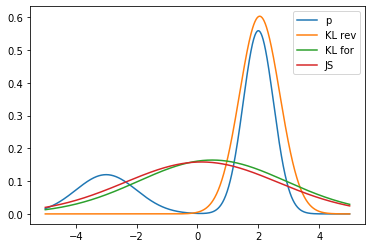

In [1116]:
plt.plot(x,gmm.log_prob(x).exp())
plt.plot(x,q_KL_rev.log_prob(x).detach().exp())
plt.plot(x,q_KL_for.log_prob(x).detach().exp())
plt.plot(x,q_JS.log_prob(x).detach().exp())
plt.legend(["p", "KL rev", "KL for", "JS"])

So that works nice! However we still have to train another neural network and performing this GAN-style min max game. This is because we assume that the transform $T$ can be represented by a neural network.

Nevertheless there are other approaches. Be $k$ a kernel function than it is associated with a feature map $\phi:\mathcal{x} \rightarrow \mathcal{H}$ where is a reproducing kernel hilber space. Then it holds that $k(x,y) = \langle \phi(x), \phi(y)\rangle$. Now assume that the function $T \in \mathcal{H}$, hence by the representer theorem it can be represented as $T(x) = \langle w, \phi(x)\rangle $ for some $w \in \mathcal{H}$. Lets consider the Gaussian kernel $k(x,y) := \exp\left(-||x-y||^2/\sigma\right)$. Imposing RKHS structure can reduce the problem to a simpler convex optimization problem (https://arxiv.org/pdf/0809.0853.pdf) but also restrcts the function space...

However there is another divergence that overs a closed form solution for such a kernel based approach, the **maximum mean discrepency MMD**. It is based on the idea to match moments between the distributions, and is defined as the distance between mean embeddings of features. Be $\varphi: \mathcal{X} \rightarrow \mathcal{H}$ a feature map then the MMD is given by
$$ MMD(P,Q) = ||\mathbb{E}_p[\varphi(X)] - \mathbb{E}_q [\varphi(X)]||_\mathcal{H}$$
For example we might choose $\varphi(x) = x$ as identitiy then we obtain
$$MMD(P,Q) = ||\mathbb{E}_p[\varphi(X)] - \mathbb{E}_q [\varphi(X)]||_\mathcal{H} = ||\mathbb{E}_p[X] - \mathbb{E}_q [X]|| = ||\mu_p - \mu_q||$$
so this MMD is just the distance between the means. If we choose for example the feature mapping $\varphi(x) = (x,x^2)$ would also distinguish distributonts not only by their mean but also by their variances.


Specifically let $k(x,y) = \langle \varphi(x), \varphi(y)\rangle_{\mathcal{H}}$, then we can interpret the MMD as following:
\begin{align*}
MMD(p,q) &= || \mathbb{E}_p [\varphi(X)]- \mathbb{E}_q[\varphi(X)]||_{\mathcal{H}}\\
&= \sup_{f \in \mathcal{H}: ||f||_{\mathcal{H}} \leq 1} \langle f, \mathbb{E}_p[\varphi(X)] - \mathbb{E}_q[\varphi(X)] \rangle_{\mathcal{H}}\\
&= \sup_{f \in \mathcal{H}: ||f||_{\mathcal{H}} \leq 1} \mathbb{E}_p[\langle f, \varphi(X) \rangle_{\mathcal{H}} ]-  \mathbb{E}_q[\langle f, \varphi(X)]\rangle_{\mathcal{H}}]\\
&= \sup_{f \in \mathcal{H}: ||f||_{\mathcal{H}} \leq 1} \mathbb{E}_p[f(X) ]-  \mathbb{E}_q[f(X)]\\
\end{align*}
Hence we can also inerpret it as the maximum, over test functions $f$ in the unit ball of $\mathcal{H}$ of the mean difference between two distributions.

\begin{align}
MMD(p,q) &= || \mathbb{E}_p [\varphi(X)] - \mathbb{E}_q [\varphi(X)]||_{\mathcal{H}}^2\\
&= \langle \mathbb{E}_p [\varphi(X)], \mathbb{E}_p [\varphi(X')]\rangle_{\mathcal{H}} + \langle \mathbb{E}_q [\varphi(X)], \mathbb{E}_q [\varphi(X')] \rangle_{\mathcal{H}} - 2 \langle \mathbb{E}_p [\varphi(X)], \mathbb{E}_q [\varphi(X')]\rangle_{\mathcal{H}} \\
&= \mathbb{E}_p [k(X,X')] + \mathbb{E}_{q} [k(X,X')] - 2\mathbb{E}_{p,q} [k(X,X')]
\end{align}
This quantities can be easily estimated using samples from q,p.

In [113]:
# Polynomial kernel
def k_p(x,y, n=2):
    return (x+y)**n
# RBF kernel 
def k_rbf(x,y, sigma=1):
    return tr.exp(-(x-y)**2/sigma)

In [116]:
def loss_k(p,q,k,mc=1024):
    mu = q.loc 
    sig = q.scale 
    k_pp = k(p.sample_n(mc), p.sample_n(mc)).mean()
    k_qq = k(mu+sig*tr.randn(mc), mu+sig*tr.randn(mc)).mean()
    k_pq = k(p.sample_n(mc), mu+sig*tr.randn(mc)).mean()
    return k_pp + k_qq -2*k_pq

In [124]:
mu = tr.zeros(1,requires_grad=True)
sig = tr.ones(1, requires_grad=True)
q = distrib.Normal(mu,sig)

In [125]:
def minimize_MMD(q,p, kernel=k_rbf):
    mu = q.loc 
    sig = q.scale
    optimizer = optim.Adam([mu,sig],lr=0.01)
    losses = []
    for i in range(500):
        optimizer.zero_grad()
        q_samples = mu + sig*tr.randn(512)
        p_samples = p.sample_n(512)
        loss = loss_k(p,q, kernel)
        loss.backward()
        optimizer.step()
        losses.append(loss.data)
    return losses

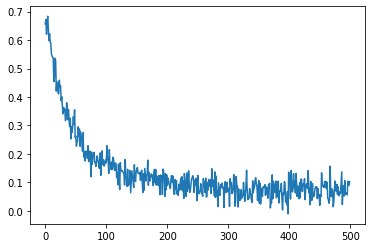

In [131]:
plt.plot(minimize_MMD(q,gmm, kernel=k_rbf))

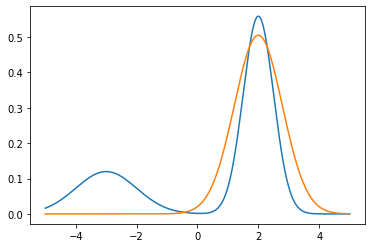

In [132]:
plt.plot(x,gmm.log_prob(x).exp())
plt.plot(x,q.log_prob(x).detach().exp())